<a href="https://colab.research.google.com/github/JohnnyTh/MNIST_convnet_pytorch/blob/master/mnist_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST dataset classification model

In [0]:
# !pip install -q torch torchvision
# !pip install torchvision
# !pip install numpy
# !pip install matplotlib

In [1]:
import sys
import os
from datetime import datetime
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [0]:
import math
import pickle
import requests
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

In [3]:
# Check if pytorch is using GPU: 
print('Used device name: {}'.format(torch.cuda.get_device_name(0)))
print('Amount of used devices: {}'.format(torch.cuda.device_count()))
print('Cuda available: {}'.format(torch.cuda.is_available()))

Used device name: Tesla K80
Amount of used devices: 1
Cuda available: True


In [4]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
MODEL_PATH = os.path.join(BASE_DIR, 'mnsit_model.pth')
LOGS_PATH = os.path.join(BASE_DIR, 'logs.txt')
print('Base directory location: {}'.format(BASE_DIR))
print('Path to stored model parameters: {}'.format(MODEL_PATH))

Base directory location: /content
Path to stored model parameters: /content/mnsit_model.pth


In [0]:
class MnistDataset(Dataset):
    """Args:
            gzip_data (file object):  an object exctracted from open zip file. 
            train_or_test (string): can be either 'train' 'test'. Needed to
                            specify which of the tuples to load using pickle.
            img_size (integer): size of the square images in dataset.
            transform (callable, optional): Optional transform to be applied
            on a sample.
    """


    def __init__(self, gzip_data, train_or_test, img_size, transform=None):
        if train_or_test == 'train':
            data = pickle.load(gzip_data, encoding='latin-1')[0]
        elif train_or_test == 'test':
            data = pickle.load(gzip_data, encoding='latin-1')[2]
        else:
            raise Exception("'train' ot 'test' keyword not specified!")
        # reshape the image data into (N, H, W, C) if you will use ToTensor()
        self.data, self.labels = data
        self.data = self.data.reshape(-1, img_size, img_size, 1)
        self.transform = transform
        self.mode = train_or_test


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


    def __str__(self):
        info = """The {} dataset consists of {} images of size {} and {} labels.
        \nImage matrix format: {}, label matrix format: {}.
               """.format(self.mode, self.data.shape[0], 
                          self.data.shape[1:], self.labels.shape[0],
                          self.data.shape, self.labels.shape)
        
        return info

class MnistSubset(Subset):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
        transform (callable, optional): Optional transform to be applied
                on a subset.
    """
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform


    def __getitem__(self, idx):
        img = self.dataset[self.indices[idx]][0]
        label = self.dataset[self.indices[idx]][1]

        if self.transform:
            img = self.transform(img)
        return img, label

In [0]:
# Download the dataset from an open source
def get_mnist_data():
    url = 'http://deeplearning.net/data/mnist/mnist.pkl.gz'
    r = requests.get(url)
    local_file_path = os.path.join(BASE_DIR, 'mnist.pkl.gz')
    with open(local_file_path, 'wb') as f:
        f.write(r.content)

get_mnist_data()

with gzip.open('/content/mnist.pkl.gz', 'r') as gzip_data:
    mnist_train = MnistDataset(gzip_data, 'train', 28, transform = transforms.ToTensor())

# create 30,000 random indices to draw a sample from train dataset
indices = np.random.randint(0, len(mnist_train), 30000)
mnist_train_transf = MnistSubset(mnist_train, indices, 
                                transform=transforms.Compose([transforms.ToPILImage(),
                                                              transforms.RandomPerspective(p=1.0), 
                                                              transforms.ToTensor()]))
# Merge original dataset and transformed subset.
mnist_train_merged = ConcatDataset([mnist_train, mnist_train_transf])

with gzip.open('/content/mnist.pkl.gz', 'r') as gzip_data:
    mnist_test = MnistDataset(gzip_data, 'test', 28, transform=transforms.ToTensor())


# Prepare train and test minibatch loaders
minibatch_size = 128

train_loader = torch.utils.data.DataLoader(mnist_train_merged, batch_size=minibatch_size, 
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=minibatch_size,
                                         shuffle=False, num_workers=2)

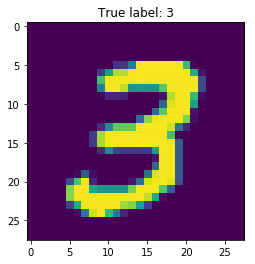

In [7]:
# Examine the data:
img, label = mnist_train_merged[7]

plt.title('True label: {}'.format(label))
plt.imshow(img.squeeze(0).numpy())

In [0]:
def same_padding_calc(inp_shape, kernel_shape, stride):
    """
       !Attention - only square image padding calculation implemented!
       Calculates the size of 'same' padding  for CONV layers.

       Args:
       kernel_shape (int or tuple): the shape of the kernel(filter).
       inp_shape (int or tuple): the shape of the input.
       stride (int).

       Returns: 
       res (int or tuple): 'same' padding size.
    """
    if type(inp_shape) == int and type(kernel_shape) == int:
        res = (inp_shape * stride - inp_shape - stride + kernel_shape) // 2
        return res
    elif type(inp_shape) == tuple and type(kernel_shape) == int:
        res = None
        return res
    elif type(inp_shape) == int and type(kernel_shape) == tuple:
        res = None
        return res
    elif type(inp_shape) == tuple and type(kernel_shape) == tuple:
        res = None
        return res
    else:
        res = None
        return res

conv_1_pad = same_padding_calc(28, 5, 1)
conv_2_pad = same_padding_calc(14, 3, 1)

In [0]:
# Various helper functions to run the model
def weights_init(m):
    """Xavier weight initialization func."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)


def minibatch_to_cuda(minibatch, model):
    """
       
    """
    inputs, labels = minibatch
    if model.cuda():
        inputs = inputs.cuda()
        labels = labels.cuda()

    return inputs, labels


def prediction_count(dataset_loader, model):
    """
    Calculates the amount of total and correct predictions of the trained model.

    Args:
         dataset_loader (DataLoader object): an instance of DataLoader class, 
                        usually corresponding to train, test or dev set.
         model (Nist_Net):an instance of custom neural network class inhereting 
                        from nn.Module class.

    Returns:
         total, correct (float): number of total and correctly guessed labels.
    """
    model = model.eval()

    total = 0
    correct = 0

    for minibatch in dataset_loader:
        inputs, labels = minibatch_to_cuda(minibatch, model)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    return total, correct


def forward_pass(dataset_loader, model):
    """
       Makes one pass through all the dataset using the provided model, collects
       model outputs.

       Args: dataset_loader (DataLoader): an instance of DataLoader class, 
                    usually corresponding to train, test, or dev set.
             model (Nist_Net): an instance of custom neural network class inhereting 
                    from nn.Module class.

       Returns: 'outputs_all', 'labels_all' (torch.Tensor objects)
    """
    model = model.eval()
    outputs_all = []
    labels_all = []
    for minibatch in dataset_loader:
        inputs, labels = minibatch_to_cuda(minibatch, model)
        output = model(inputs)

        outputs_all.append(output)
        labels_all.append(labels)

    outputs_all = torch.cat(outputs_all)
    labels_all = torch.cat(labels_all)

    return outputs_all, labels_all

def plot_train_results(epochs, costs, train_error, test_error):
    """
       Plots learning curve, train error and test error w.r.t. epochs
       Args:
            epochs (int): number of traning epochs
            costs(list): values returned by cost(loss) function during the training
            train_error (dict): contains lists of epochs and respective train dataset errors
            test_error (dict): contains lists of epochs and respective test dataset errors
    """
    plt.figure( figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')

    plt.plot(np.arange(epochs), costs, color='r', label='cost')
    ax1 = plt.gca()
    ax1.set(xlabel= 'Num. of epochs', ylabel = 'Cost', title='Cost vs epochs')
    ax1.set_xlim(left=np.arange(epochs).min(), right = np.arange(epochs).max())
    ax1.set_ylim(min(costs), max(costs))
    ax1.legend(loc = 9)

    ax2 = ax1.twinx() 
    ax2.plot(train_error['epoch'], train_error['error'], label = 'train set error')
    ax2.plot(test_error['epoch'], test_error['error'], label = 'test set error')
    ax2.set(ylabel='Error, %')
    ax2.set_ylim()
    ax2.legend()

    plt.plot()

def check_gpu_memory():
    memory_usage = (torch.cuda.memory_allocated(device)/torch.cuda.get_device_properties(device).total_memory)*100
    return  memory_usage


# NN info:

IN: Tensor (N, 1, 28, 28)

>NN structure:
1. CONV2d(5x5x1, s=1, p='same') -> ReLU
2. Max.POOl(2x2, s=2)
3. CONV2d(3x3x32, s=1, p='same') -> ReLU
4. Max.POOL(2x2, s=2)
5. Dropout() -> FC(256) -> ReLU -> Dropout()
6. FC(128) -> ReLU -> Dropout()
7. FC(10)

>Tensor shapes:
0. N, 1, 28, 28
1. N, 32, 28, 28        Params: 5 x 5 x 32 (weights) + 32 (intercept)
2. N, 32, 14, 14 
3. N, 64, 14, 14        Params: 3 x 3 x 64 (weights) + 64 (intercept)
4. N, 64, 7, 7
5. N, 256, 3136         Params: 128 x (64 x 7 x 7) + 128 (intercept)
6. N, 128, 256           Params: 64 x 128 + 64
7. (N, 10)

OUT: Tensor (N, 10)

In [11]:
class Nist_Net(nn.Module):


    def __init__(self):
        # super function to call init method of parent class nn.Module
        super(Nist_Net, self).__init__()

        """
        Role of the 'features' layer - recognition of various visual patterns in 
        the images. The first CONV - ReLU - MaxPool layer detecs simplier features
        (vertical, horizontal edges, etc.), while the second such layer identifies
        more complex patterns(e.g. sahpes corresponding to different numbers) 
        composed of the features.
        """
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=conv_1_pad),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
                                      
            nn.Conv2d(32, 64, 3, stride=1, padding=conv_2_pad),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)                     
        )

        """
        Role of the 'fc' layers - making a prediction which of the target numbers 
        the visual pattern detected by the 'features' corresponds the most to.
        This can be done because FC layers have (as the name implies) connections
        with all the units from the previous layers.
        """
        self.fc_1 = nn.Sequential(
           nn.Linear(64 * 7 * 7, 256),
           nn.ReLU(),
           )
        self.fc_2 = nn.Sequential(
           nn.Linear(256, 128),
           nn.ReLU(),
        )
        self.fc_3 = nn.Linear(128, 10)

        """Dropout is used to randomly zero some of the elements of layers' inputs 
        in order to make the model generalize better and prevent co-adaptaion 
        of neurons."""
        self.Dropout_1 = nn.Dropout(p=0.2)
        self.Dropout_2 = nn.Dropout(p=0.35)


    def forward(self, x):
        """Performs forward propagation

           Args:
                x (Tensor): a tensor containing input features.
        """
        x = self.features(x)
        x = x.view(x.shape[0], -1)

        # Perform dropout before and after the first fc layer
        if self.training:
            x = self.Dropout_2(x)
        x = self.fc_1(x)
        if self.training:
            x = self.Dropout_1(x)

        x = self.fc_2(x)
        if self.training:
            x = self.Dropout_1(x)

        x = self.fc_3(x)
        return x

net = Nist_Net()

# Define a Loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.003)

# Set a learning rate scheduler
lambda_1 = lambda epoch: 0.89 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_1)

load_checkpoint = False

if load_checkpoint:
    checkpoint = torch.load(MODEL_PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    # reset the weights of the model using Xavier init 
    # if the weights were not loaded from checkpoint
    net.apply(weights_init)

# Select the available gpu and convert the net into cuda tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

print(net)
gpu_usage = check_gpu_memory()
print('Current GPU memory usage: {} %'.format(gpu_usage))

Nist_Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc_3): Linear(in_features=128, out_features=10, bias=True)
  (Dropout_1): Dropout(p=0.2)
  (Dropout_2): Dropout(p=0.35)
)


> Code to run the training loop and visiualize the reuslts:



Cost after epoch 1: 0.33843361871242544
Cost after epoch 2: 0.13012532846927635
Cost after epoch 3: 0.10471451134979724
Cost after epoch 4: 0.08842835466265676
Cost after epoch 5: 0.0759521977648139
Training set error: 1.11%
Test set error: 0.64%
Cost after epoch 6: 0.03297852790504694
Cost after epoch 7: 0.027587552587688018
Cost after epoch 8: 0.02381175220161675
Cost after epoch 9: 0.02309813582450153
Cost after epoch 10: 0.020019448657333846
Training set error: 0.5599999999999999%
Test set error: 0.47000000000000003%
Cost after epoch 11: 0.020092244341969483
Cost after epoch 12: 0.016196092435717582
Cost after epoch 13: 0.015911092959344394
Cost after epoch 14: 0.014016161918640135
Cost after epoch 15: 0.013982469142973415
Training set error: 0.44%
Test set error: 0.52%
Cost after epoch 16: 0.012749470280110822
Cost after epoch 17: 0.010871443253755561
Cost after epoch 18: 0.011274723510444165
Cost after epoch 19: 0.01070424481034278
Cost after epoch 20: 0.011252980281412603
Traini

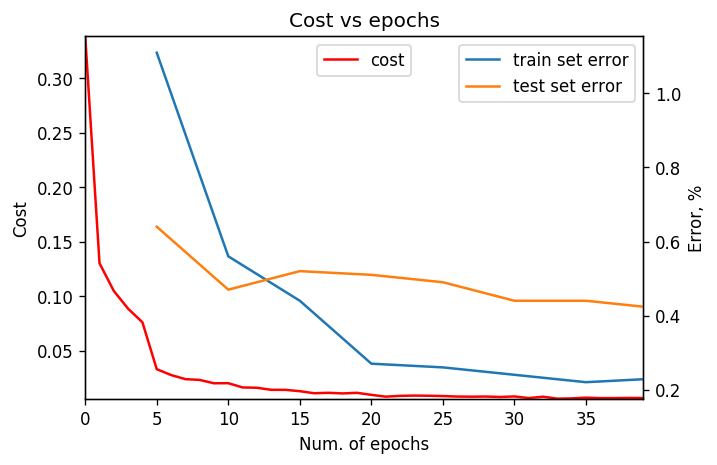

In [13]:
# Some initial runtime model  parameters
epochs = 40

costs = []
train_error = {'epoch': [], 'error': []}
test_error = {'epoch': [], 'error': []}
torch.manual_seed(42)

# Set a log recorder
dateTimeObj = datetime.now()
time = dateTimeObj.strftime("%d-%b-%Y %H:%M:%S")
f = open(LOGS_PATH, 'a+')
# Record the data regarding the model structure and params before the train session
f.write('\n' + net.__repr__())
f.write('\n' +'Initial learning rate: '+ str(optimizer.state_dict()['param_groups'][0]['lr'])+'\n')
f.write('Starting session at {}\n'.format(time))


net = net.train()
for epoch in range(1, epochs+1):

    minibatch_cost = 0.
    for minibatch in train_loader:
        inputs, labels = minibatch_to_cuda(minibatch, net)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        minibatch_cost += loss.item() / len(train_loader)

    if epoch % 1 == 0:
        costs.append(minibatch_cost)
        record_1 = 'Cost after epoch {}: {}'.format(epoch, minibatch_cost)
        print(record_1)
        f.write(record_1 + '\n')

    # Print train and test sets accuracy after each 5th epoch:
    if epoch % 5 == 0:

        # swtich the model to eval mode to disable the dropout  layers
        total_train, correct_train = prediction_count(train_loader, net)
        total_test, correct_test = prediction_count(test_loader, net)

        train_error['epoch'].append(epoch)
        train_error['error'].append(round(1 - correct_train/total_train, 4)*100)
        test_error['epoch'].append(epoch)
        test_error['error'].append(round(1 - correct_test/total_test, 4)*100)

        record_2 = 'Training set error: {}%'.format(train_error['error'][-1])
        record_3 = 'Test set error: {}%'.format(test_error['error'][-1])
        print(record_2)
        print(record_3)

        f.write(record_2 + '\n' +  record_3 + '\n')


    # Save the checkpoint
    if epoch > 10 and costs[-1] < min(costs[0:-1]):
        torch.save({'epoch': epoch,
                   'model_state_dict': net.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'cost': costs[-1]
                    }, MODEL_PATH)

    # Execute one step of learning rate scheduler (to apply learning rate decay)
    scheduler.step()

print('Training completed!')

dateTimeObj = datetime.now()
time = dateTimeObj.strftime("%d-%b-%Y %H:%M:%S")
f.write('Training completed at {}\n\n\n'.format(time))
f.close()

# Visualize the training results and model's performance
plot_train_results(epochs, costs, train_error, test_error)

In [0]:
# Make a forward pass and select some mislabeled images:
num_images = 6

outputs, labels = forward_pass(test_loader, net)
_, predicted = torch.max(outputs, 1)

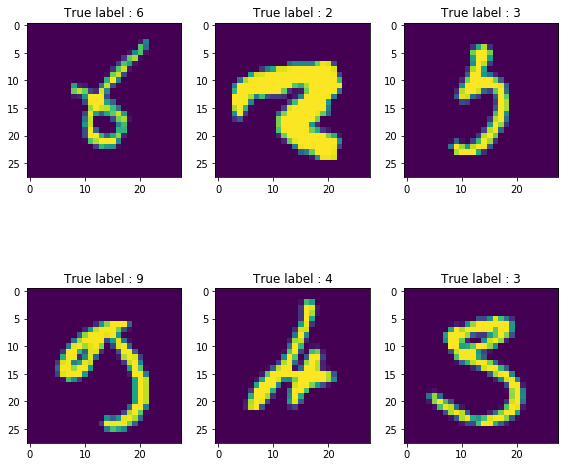

In [133]:
# collect the indices of the mislabeled images
idx = torch.nonzero(predicted != labels).squeeze()
selected = np.random.choice(len(idx), num_images, replace=False)
selected_idx = idx[selected].tolist()

fig, axes = plt.subplots(2, 3, figsize=(8,8))
for ax, idx in zip(axes.flat, selected_idx):
    ax.set_title('True label : {}'.format(mnist_test[idx][1]))
    ax.imshow(mnist_test[idx][0].squeeze(0).numpy())
plt.tight_layout()
plt.show()